In [1]:
!pip install bitsandbytes>=0.39.0 -q
!pip install accelerate

In [148]:
from langchain import FewShotPromptTemplate, PromptTemplate
from langchain.chains import LLMChain
from langchain.llms import Ollama
import matplotlib.pyplot as plt
from dataclasses import dataclass
from transformers import AutoModelForCausalLM, AutoTokenizer
from langchain import HuggingFaceHub
import seaborn as sns
from datetime import datetime
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm
import re

In [149]:
import os

os.environ["HUGGINGFACEHUB_API_TOKEN"] = ''

In [150]:
!huggingface-cli login --token ''

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /Users/shubhagarwal/.cache/huggingface/token
Login successful


In [113]:
@dataclass
class Scaler:
    transform: callable = lambda x: x
    inv_transform: callable = lambda x: x

In [155]:
class LLMTime:
    
    def __init__(self, train, test, alpha=0.95, beta=0.3, batch_length=400, basic=False, temperature=0.5, do_sample=True, model_name="mistralai/Mistral-7B-v0.1", repetition_penalty=1.0, ollama = False, num_samples=10):
        self.ollama = ollama
        self.model_name = model_name
        self.train = train
        self.test = test
        self.alpha = alpha
        self.beta = beta
        self.batch_length = batch_length
        self.basic = basic
        self.temperature = temperature
        self.do_sample = do_sample
        self.repetition_penalty = repetition_penalty
        self.scalers = None
        self.input_str = None
        self.test_str = None
        self.tokenizer = None
        self.model = None
        self.good_tokens = None
        self.bad_tokens = None
        self.output = None
        self.transformed_output_arr = None
        self.num_samples = num_samples
        self.preprocess_data()
    
    @staticmethod
    def get_scaler(history, alpha=0.95, beta=0.3, basic=False):
        history = history[~np.isnan(history)]
        if basic:
            q = np.maximum(np.quantile(np.abs(history), alpha),.01)
            def transform(x):
                return x / q
            def inv_transform(x):
                return x * q
        else:
            min_ = np.min(history) - beta*(np.max(history)-np.min(history))
            q = np.quantile(history-min_, alpha)
            if q == 0:
                q = 1
            def transform(x):
                return (x - min_) / q
            def inv_transform(x):
                return x * q + min_
        return Scaler(transform=transform, inv_transform=inv_transform)
    
    def convert_array_to_string(self, arr):
        rounded_values = [round(val * 1000) for val in arr]
        str_values = [str(val) for val in rounded_values]
        result_string = ",".join(str_values)
        return result_string

    def preprocess_data(self):
        train = self.train
        test = self.test
        if not isinstance(train, list):
            train = [train]
            test = [test]
        n_val = len(train)
        for i in range(len(train)):
            if not isinstance(train[i], pd.Series):
                train[i] = pd.Series(train[i], index=pd.RangeIndex(len(train[i])))
                test[i] = pd.Series(test[i], index=pd.RangeIndex(len(train[i]), len(test[i])+len(train[i])))
        alpha = self.alpha
        beta = self.beta
        basic = self.basic
        self.scalers = [self.get_scaler(train[i].values, alpha=alpha, beta=beta, basic=basic) for i in range(len(train))]
        input_arrs = [train[i].values for i in range(len(train))]
        transformed_input_arrs = np.array([scaler.transform(input_array) for input_array, scaler in zip(input_arrs, self.scalers)])
        input_str = self.convert_array_to_string(transformed_input_arrs[0])
        test_arrs = [test[i].values for i in range(len(test))]
        transformed_test_arrs = np.array([scaler.transform(input_array) for input_array, scaler in zip(test_arrs, self.scalers)])
        test_str = self.convert_array_to_string(transformed_test_arrs[0])
        self.input_str = input_str
        self.test_str = test_str
        return input_str, test_str, self.scalers
    
    def few_shot(self):
        input_str = self.input_str
        examples = []
        batch_length = self.batch_length
        for i in range(batch_length, len(input_str) - batch_length, batch_length):
            examples.append({
                "input": input_str[i-batch_length:i],
                "output": input_str[i:i+batch_length//5]
            })
        example_template = """
        {{input}} -> {{output}}
        """
        
        prompt = PromptTemplate.from_template(example_template, template_format='jinja2')
        
        few_shot_prompt = FewShotPromptTemplate(
            examples=examples,
            example_prompt=prompt,
            prefix="",
            suffix="{input} ->",
            input_variables=["input"],
            example_separator="",
        )
        if not self.ollama:
            self.tokenizer = AutoTokenizer.from_pretrained(self.model_name, padding_side="left")
            good_tokens_str = list("0123456789,")
            good_tokens = [self.tokenizer.convert_tokens_to_ids(token) for token in good_tokens_str]
            self.bad_tokens = [i for i in range(len(self.tokenizer)) if i not in good_tokens]
            self.good_tokens = [i for i in range(len(self.tokenizer)) if i in good_tokens]
            self.model = HuggingFaceHub(repo_id=self.model_name, model_kwargs={
                "temperature": self.temperature, 
                "do_sample": self.do_sample, 
                "repetition_penalty": self.repetition_penalty,
                "max_new_tokens": self.batch_length//5, 
                "min_new_tokens": self.batch_length//5,
                "force_words_ids": [[t] for t in self.good_tokens],
                "bad_words_ids": [[t] for t in self.bad_tokens]
            })
        else:
            self.model = Ollama(model=self.model_name)
        chain = LLMChain(llm=self.model, prompt=few_shot_prompt)
        output = ""
        inp = input_str
        i = 0
        while len(output) < len(self.test_str) and i < 1000:
            print(len(output), len(self.test_str))
            i+=1
            inputp = inp[-self.batch_length:]
            firstComma = inputp.find(',')
            lastComma = inputp.rfind(',')
            inputp = inputp[firstComma+1:lastComma]
            out = chain.predict(input=inputp)
            print(out)
            sub = out.split('>')[-1]
            sub = sub.strip()
            sub = sub.replace('\n', '').replace('\r', '')
            print(f'Input {i} : {inputp}')
            print(f'Output {i} : {sub}')
            pattern = r'^[0-9,]+$'
            if not bool(re.match(pattern, sub)):
                continue
            firstComma = sub.find(',')
            lastComma = sub.rfind(',')
            if firstComma == -1 or lastComma == -1 or firstComma == lastComma:
                continue
            sub = sub[firstComma+1:lastComma]
            examples.append({
                "input": inputp,
                "output": sub
            })
            few_shot_prompt = FewShotPromptTemplate(
                examples=examples,
                example_prompt=prompt,
                prefix="",
                suffix="{input} ->",
                input_variables=["input"],
                example_separator="",
            )
            chain = LLMChain(llm=self.model, prompt=few_shot_prompt)
            if len(sub) == 0:
                break
            output = output + ',' + sub
            inp = inp[:inp.rfind(',')]
            inp = inp + ',' + sub
            print(output)
            print(len(output), len(self.test_str))
        self.output = output
        return output
      
    @staticmethod    
    def invert_string_to_array(string_values):
        string_values = string_values.replace(" ", "")
        if string_values[-1] == ',':
            string_values = string_values[:len(string_values) - 1]
        str_values_list = string_values.split(',')
        float_values = [float(val) if val.strip() != '' else 0.0 for val in str_values_list]
        original_values = [val / 1000 for val in float_values]
        return original_values

    def get_original_array(self, output_str):
        output_arr = self.invert_string_to_array(string_values=output_str)
        output_arr = np.array(output_arr)
        transformed_output_arr = self.scalers[0].inv_transform(output_arr)
        self.transformed_output_arr = transformed_output_arr
        return transformed_output_arr
    
    def plot(self, input, outputs, m):
        model_parameters = {
            "alpha": self.alpha,
            "beta": self.beta,
            "batch_length": self.batch_length,
            "basic": self.basic,
            "temperature": self.temperature,
            "do_sample": self.do_sample,
            "repetition_penalty": self.repetition_penalty,
            "num_samples": self.num_samples
        }

        sns.set(style="whitegrid")
        fig, ax = plt.subplots(figsize=(10, 6))
        plt.title(f"Zero Shot {self.model_name}")
        plt.axvline(x=m, color='k', linestyle='--', label='Train-Test Split')
        min_output = np.min(outputs, axis=0)
        max_output = np.max(outputs, axis=0)
        median_output = np.median(outputs, axis=0)
        mean_output = np.mean(outputs, axis=0)

        for i in range(len(outputs)):
            plt.plot(outputs[i], color='darkgray', alpha=0.5, label='_nolegend_')

        plt.plot(min_output, color='green', linestyle='--', label='Min Predicted')
        plt.plot(max_output, color='orange', linestyle='--', label='Max Predicted')
        plt.plot(median_output, color='red', label='Median Predicted')
        plt.plot(mean_output, color='violet', label='Mean Predicted')

        input = input[:len(median_output)]

        plt.plot(input, color='blue', label='Actual')
        plt.legend()

        plt.grid(True)
        plt.xlabel('Time')
        sns.set_palette("husl")

        mae = mean_absolute_error(input[-(len(input)-m):], median_output[-(len(median_output)-m):])
        rmse = np.sqrt(mean_squared_error(input[-(len(input)-m):], median_output[-(len(median_output)-m):]))
        std_dev = np.std(outputs, axis=0)

        error_text = f"\n\nMedian MAE: {mae:.2f}\nMedian RMSE: {rmse:.2f}\nStandard Deviation: {np.mean(std_dev):.2f}"
        ax.text(1.05, 0.4, error_text, transform=ax.transAxes, fontsize=10, verticalalignment='center')
        textstr = '\n'.join([f"{key}: {value}" for key, value in model_parameters.items()])
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.text(1.05, 0.6, textstr, transform=ax.transAxes, fontsize=10, verticalalignment='center', bbox=props)

        model_name = self.model_name.split('/')[1]
        current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        random_number = np.random.randint(0, 1000)
        filename = f"plts/{model_name}-zero-shot-{current_time}-{random_number}.png"

        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Plot saved as {filename}")
    
    def run(self):
        outputs =[]
        for i in range(self.num_samples):
            output = self.few_shot()
            outputs.append(output)
        r = np.array(outputs)
        self.plot_and_return(r)
        return r
        
    def plot_and_return(self, outputs):
        l = []
        input_arr = self.get_original_array(self.input_str + ',' + self.test_str)
        inp = self.get_original_array(self.input_str)
        m = len(inp)
        min_len = 9999999999
        for i, output in enumerate(outputs):
            transformed_output_arr = self.get_original_array(self.input_str + ',' + output)
            min_len = min(min_len, len(transformed_output_arr))
            l.append(transformed_output_arr)
        input_arr = input_arr[:min_len]
        for i, x in enumerate(l):
            l[i] = x[:min_len]
        self.plot(input_arr, np.array(l), m)

In [156]:
from sklearn.datasets import fetch_openml

co2 = fetch_openml(data_id=41187, as_frame=True, parser='auto')
co2_data = co2.frame
co2_data["date"] = pd.to_datetime(co2_data[["year", "month", "day"]])
co2_data = co2_data.sort_values(by="date")
co2_data = co2_data[["date", "co2"]].set_index("date")
co2_data=co2_data.squeeze()
train_2, test_2 = co2_data[:int(0.7*len(co2_data))], co2_data[int(0.7*len(co2_data)):]
print(train_2.shape,test_2.shape,co2_data.shape)

(1557,) (668,) (2225,)


In [157]:
llm_time = LLMTime(train_2, test_2, alpha=1, beta=0.1, batch_length=5000, basic=False, temperature=0.3, do_sample=True, ollama=False, repetition_penalty=1.2, num_samples=1)

0 3248
225,238,246,249,246,260,262,266,264,253,275,286,292,290,284,297,292,286,279,292,284,281,281,286,286,284,281,253,231,231,200,218,216,207,200,205,174,170,183,196,189,192,207,227,220,225,222,229,229,238,235,253,257,266,268,271,281,279,284,290,290,299,306,321,323,327,330,321,332,334,325,338,332,327,325,317,306,308,273,262,225,235,242,205,209,207,198,198,205,214,207,233,244,249,262,262,268,273,273,286,308,290,292,306,301,308,301,317,314,312,336,341,345,356,358,347,354,352,352,345,317,321,306,306,297,297,288,279,275,253,244,244,231,229,222,218,218,240,231,240,244,251,264,277,275,284,292,286,295,297,299,299,306,301,312,319,312,312,327,327,336,347,347,354,349,363,367,354,365,371,367,369,365,352,345,347,334,330,319,297,292,288,281,275,253,268,238,240,255,255,249,242,260,262,275,281,288,297,308,317,312,317,332,338,334,334,330,338,349,356,365,369,373,371,380,400,387,387,409,415,393,395,406,387,391,391,382,378,376,369,363,343,343,312,299,312,292,303,306,286,277,284,288,286,292,301,303,312,3

ValueError: Found input variables with inconsistent numbers of samples: [668, 794]

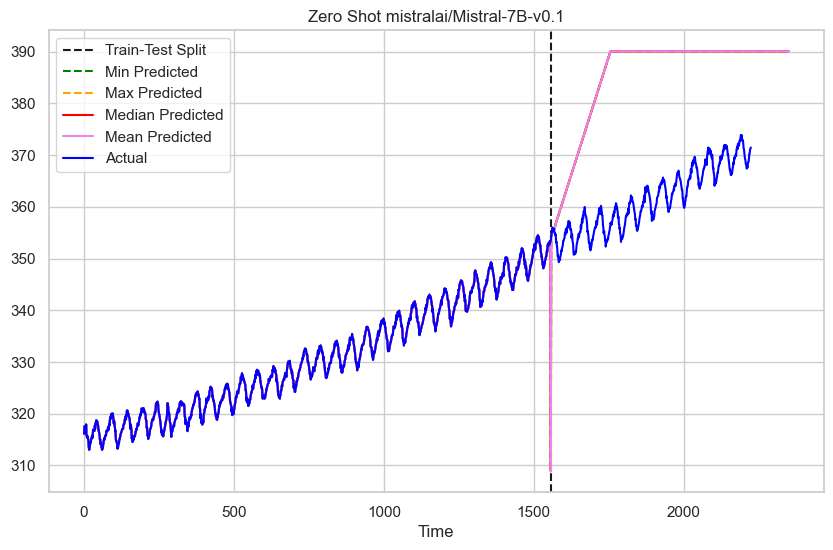

In [158]:
out = llm_time.run()

In [42]:
out

NameError: name 'out' is not defined

In [83]:
llm_time.input_str

'318,342,348,346,324,334,346,354,311,311,303,305,307,297,295,277,264,254,258,264,275,285,283,289,299,299,305,307,311,303,334,328,328,332,330,330,350,338,348,362,360,371,356,365,367,358,352,350,332,332,324,318,307,293,295,277,283,273,264,264,254,256,262,262,277,283,291,299,297,295,307,311,309,309,324,330,326,328,328,334,344,336,334,350,356,350,369,383,377,377,391,395,393,397,397,385,397,385,377,358,369,365,354,342,328,330,297,289,289,285,279,260,266,260,273,279,279,285,297,297,303,311,315,320,324,328,330,336,336,336,336,350,354,356,356,367,375,371,385,387,375,391,389,409,405,409,403,397,397,389,385,381,377,365,338,354,354,342,330,299,299,293,285,295,307,293,303,303,309,311,309,320,326,326,336,334,338,344,354,358,356,350,356,362,375,383,381,385,395,391,401,401,418,411,403,414,411,418,420,416,414,407,399,401,399,395,377,371,369,340,344,328,309,313,297,303,309,309,313,324,334,336,338,342,348,358,367,371,375,373,371,375,383,383,391,393,403,401,403,416,438,436,436,442,442,444,438,434,414,405

In [84]:
out

'\n        318,342,348,346,324,334,346,354,311,311,303,305,307,297,295,277,264,254,258,264,275,285,283,289,299,299,305,307,311,303,334,328,328,332,330,330,350,338,348,362,360,371,356,365,367,358,352,350,332,332,324,318,307,293,295,277,283,273,264,264,254,256,262,262,277,283,291,299,297,295,307,311,309,309,324,330,326,328,328,334,344,336,334,350,356,350,369,383,377,377,391,395,393,397,397,385,397,385,377,358,369,365,354,342,328,330,297,289,289,285,279,260,266,260,273,279,279,285,297,297,303,311,315,320,324,328,330,336,336,336,336,350,354,356,356,367,375,371,385,387,375,391,389,409,405,409,403,397,397,389,385,381,377,365,338,354,354,342,330,299,299,293,285,295,307,293,303,303,309,311,309,320,326,326,336,334,338,344,354,358,356,350,356,362,375,383,381,385,395,391,401,401,418,411,403,414,411,418,420,416,414,407,399,401,399,395,377,371,369,340,344,328,309,313,297,303,309,309,313,324,334,336,338,342,348,358,367,371,375,373,371,375,383,383,391,393,403,401,403,416,438,436,436,442,442,444,438,4

Plot saved as plts/starcoder2-15b-few-shot-2024-03-02_14-27-42-613.png


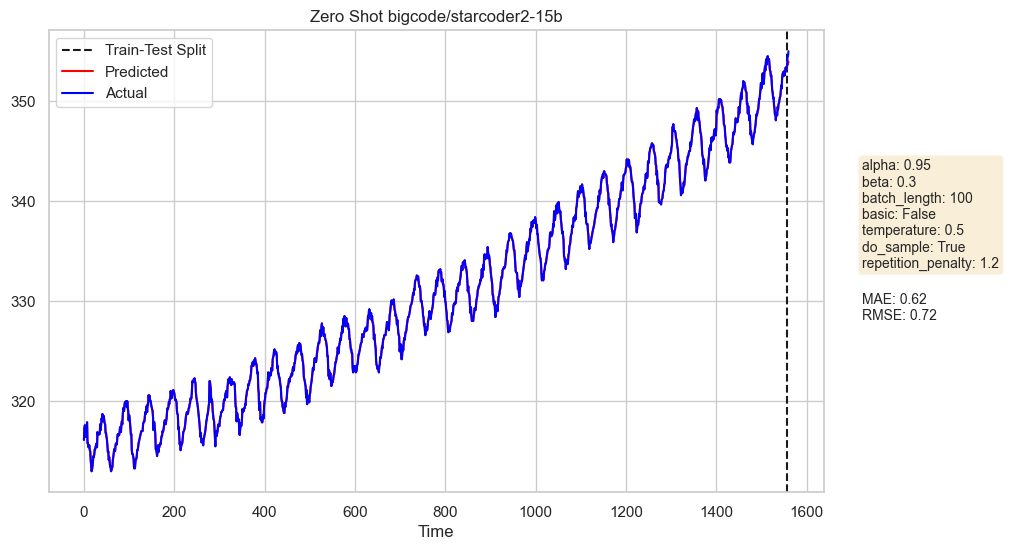

In [79]:
llm_time.plot_and_return('1083,1089,1085,1091')

In [49]:
import itertools
from tqdm import tqdm
from joblib import Parallel, delayed
import numpy as np

batch_length_values = [500, 1000, 3000, 5000, 6000]
temperature_values = [0.1, 0.3, 0.5, 0.7, 0.9]
repetition_penalty_values = [1.0, 1.3, 1.6, 1.9]
model_name_values = ['mistralai/Mistral-7B-Instruct-v0.2', 'mistralai/Mistral-7B-v0.1']

hyperparameter_combinations = list(itertools.product(batch_length_values, temperature_values, repetition_penalty_values,
                                                     model_name_values))

dic = {}
counter = 0

def train_model(combination):
    batch_length, temperature, repetition_penalty, model_name = combination

    model = LLMTime(train_2,
                    test_2,
                    alpha=0.95,
                    beta=0.3,
                    batch_length=batch_length,
                    basic=False,
                    temperature=temperature,
                    do_sample=True,
                    model_name=model_name,
                    repetition_penalty=repetition_penalty)

    try:
        out = model.run()
        print("Success")
        return combination, out
    except Exception as e:
        print(str(e))
        return combination, str(e)

num_jobs = 7
results = Parallel(n_jobs=num_jobs)(delayed(train_model)(combination) for combination in tqdm(hyperparameter_combinations))
dic = {combination_str: accuracy for combination_str, accuracy in results}

  7%|▋         | 14/200 [00:30<07:54,  2.55s/it]

could not convert string to float: '...(thesequencegoeson'
Plot saved as plts/Mistral-7B-Instruct-v0.2-zero-shot-2024-03-09_17-32-54-125.png
Success
Plot saved as plts/Mistral-7B-v0.1-zero-shot-2024-03-09_17-32-54-786.png
Success
Plot saved as plts/Mistral-7B-v0.1-zero-shot-2024-03-09_17-32-55-460.png
Success
Plot saved as plts/Mistral-7B-v0.1-zero-shot-2024-03-09_17-32-55-653.png
Success
Plot saved as plts/Mistral-7B-Instruct-v0.2-zero-shot-2024-03-09_17-32-56-568.png
Success
Plot saved as plts/Mistral-7B-Instruct-v0.2-zero-shot-2024-03-09_17-33-00-314.png
Success


 10%|█         | 21/200 [00:46<07:13,  2.42s/it]

Plot saved as plts/Mistral-7B-v0.1-zero-shot-2024-03-09_17-33-10-519.png
Success
Plot saved as plts/Mistral-7B-Instruct-v0.2-zero-shot-2024-03-09_17-33-10-784.png
Success
Plot saved as plts/Mistral-7B-Instruct-v0.2-zero-shot-2024-03-09_17-33-12-223.png
Success
Plot saved as plts/Mistral-7B-Instruct-v0.2-zero-shot-2024-03-09_17-33-13-542.png
Success
Plot saved as plts/Mistral-7B-v0.1-zero-shot-2024-03-09_17-33-17-903.png
Success
Plot saved as plts/Mistral-7B-v0.1-zero-shot-2024-03-09_17-33-18-155.png
Success
Plot saved as plts/Mistral-7B-v0.1-zero-shot-2024-03-09_17-33-18-5.png
Success


 14%|█▍        | 28/200 [01:01<06:43,  2.34s/it]

Plot saved as plts/Mistral-7B-v0.1-zero-shot-2024-03-09_17-33-26-688.png
Success
Plot saved as plts/Mistral-7B-Instruct-v0.2-zero-shot-2024-03-09_17-33-28-801.png
Success
could not convert string to float: 'where"(...)"representsanyportionofthisstringthatmayvarybetweendifferentoccurrencesbutdoesnotaffectwhetherit\'sconsideredtobeaninstanceofourtargetpattern-i.e.'
could not convert string to float: '...(thesequencegoesonlikethisforaverylongtime'
Plot saved as plts/Mistral-7B-v0.1-zero-shot-2024-03-09_17-33-33-173.png
Success
Plot saved as plts/Mistral-7B-Instruct-v0.2-zero-shot-2024-03-09_17-33-35-411.png
Success
Plot saved as plts/Mistral-7B-v0.1-zero-shot-2024-03-09_17-33-36-13.png
Success


 18%|█▊        | 35/200 [01:16<06:10,  2.24s/it]

could not convert string to float: '"'
could not convert string to float: '")'
could not convert string to float: '{(2)^3}'
Plot saved as plts/Mistral-7B-Instruct-v0.2-zero-shot-2024-03-09_17-33-52-264.png
Success
Plot saved as plts/Mistral-7B-v0.1-zero-shot-2024-03-09_17-33-54-845.png
Success
Plot saved as plts/Mistral-7B-Instruct-v0.2-zero-shot-2024-03-09_17-33-54-576.png
Success


 21%|██        | 42/200 [01:31<05:51,  2.23s/it]

429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-Instruct-v0.2 (Request ID: AdFVd3JzYKuY0FstRmQDV)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-Instruct-v0.2 (Request ID: Ki6gVr0xQlYqe5oBzNinF)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-v0.1 (Request ID: zyXbTKxBkgmlpfZT_6iEN)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inferen

 24%|██▍       | 49/200 [01:32<03:55,  1.56s/it]

429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-Instruct-v0.2 (Request ID: Ncp6TR-oAPRCyhAABHzUO)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-v0.1 (Request ID: h6MTE9vTkx5VIn9N3ZIff)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-Instruct-v0.2 (Request ID: 4cUPyUClchsCKaz-pq94C)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inferen

 28%|██▊       | 56/200 [01:34<02:41,  1.12s/it]

429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-v0.1 (Request ID: YEpJMFj8DJASGJoeP3sFb)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-v0.1 (Request ID: 7u7afEeSKnG92xTDpFc0V)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-Instruct-v0.2 (Request ID: X7Gyp59C3cdQHQbIDlD8Q)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inference.huggin

 32%|███▏      | 63/200 [01:35<01:52,  1.22it/s]

429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-Instruct-v0.2 (Request ID: NFSvW1Os1CjdpOc94OeQc)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-v0.1 (Request ID: Zj59ZT-Hdpg7onfZ9836T)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-v0.1 (Request ID: S91bhVCYujNHATXCFqjUj)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inference.huggin

 35%|███▌      | 70/200 [01:36<01:21,  1.60it/s]

429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-Instruct-v0.2 (Request ID: z_X7_E1t-eyGWxv-wtIyB)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-v0.1 (Request ID: tzzNwaeOyd6VcOBoSpD_x)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-Instruct-v0.2 (Request ID: iFQtqUbNd_uHJPaF8i66v)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inferen

 38%|███▊      | 77/200 [01:37<00:59,  2.07it/s]

429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-v0.1 (Request ID: oqLTP-zCX5bfzu5z0TVEQ)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-Instruct-v0.2 (Request ID: GUctfF5YI29b4BrF6hr_B)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-v0.1 (Request ID: iSb4zOBfNCu4ulmjprqry)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inference.huggin

 42%|████▏     | 84/200 [01:38<00:43,  2.65it/s]

429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-Instruct-v0.2 (Request ID: JSLzJqyxfcZN8gh9goWcC)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-v0.1 (Request ID: l5zQwbBhwOYQlLkowglx6)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-Instruct-v0.2 (Request ID: zrwPHEh1780UfLk2KC1sE)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inferen

 46%|████▌     | 91/200 [01:39<00:33,  3.21it/s]

429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-v0.1 (Request ID: du51Ofb0th4GK4ivGahPr)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-Instruct-v0.2 (Request ID: 2jjK2qF2xvJf-xYQJcXaN)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-v0.1 (Request ID: Yry50iZA56_IUatCCZsU1)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inference.huggin

 49%|████▉     | 98/200 [01:40<00:26,  3.82it/s]

429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-v0.1 (Request ID: 8sF52ZB6Fyea90bU5i7L9)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-Instruct-v0.2 (Request ID: 7Vk-zlZzc8VKYBHwamLMq)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-Instruct-v0.2 (Request ID: mI8Pm5V6kFX-dCeQcjAad)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inferen

 52%|█████▎    | 105/200 [01:42<00:22,  4.14it/s]

429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-v0.1 (Request ID: GDk17HrfkLij5CxO5uaxs)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-Instruct-v0.2 (Request ID: 7IML9mT-4cCpSx9sZdXEM)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-v0.1 (Request ID: n4EugtiOoQZzFK4A9XJo4)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inference.huggin

 56%|█████▌    | 112/200 [01:43<00:19,  4.55it/s]

429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-Instruct-v0.2 (Request ID: zBCDP9hW_eYRWDcD8IqWK)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-v0.1 (Request ID: 6ksmKD2EGfLBVCrRltRjR)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-Instruct-v0.2 (Request ID: Amo-Quw8faFoiFbC-dMmY)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inferen

 60%|█████▉    | 119/200 [01:44<00:16,  5.01it/s]

429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-v0.1 (Request ID: VTFyBwD73ekWyUtd5btZW)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-Instruct-v0.2 (Request ID: GHtBfCDmAt0La2YXbWJAe)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-Instruct-v0.2 (Request ID: mRsbpYTLKQW_IblBp_IN7)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inferen

 63%|██████▎   | 126/200 [01:45<00:13,  5.34it/s]

429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-Instruct-v0.2 (Request ID: 2oWjmn1rfzfFwwiNs9S_Y)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-v0.1 (Request ID: hVJZrsIWbAVd2juslVPXP)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-Instruct-v0.2 (Request ID: jyMvePZPo6mgVqrH7CDLj)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inferen

 66%|██████▋   | 133/200 [01:46<00:12,  5.56it/s]

429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-v0.1 (Request ID: PVI1XChGBDcBo42x3E19h)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-Instruct-v0.2 (Request ID: G2GKMcmWBuEP7osenvdjC)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-v0.1 (Request ID: qwXPA5HkOef1gvbQamYFv)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inference.huggin

 70%|███████   | 140/200 [01:47<00:10,  5.89it/s]

429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-Instruct-v0.2 (Request ID: aX01pGjyeh4hlmyiWMICK)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-v0.1 (Request ID: CI7JNFNmEdRxEwJzasdwO)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-Instruct-v0.2 (Request ID: taBeOF4bi_fNBqPQSGGZq)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inferen

 74%|███████▎  | 147/200 [01:48<00:08,  5.93it/s]

429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-Instruct-v0.2 (Request ID: -GUwixW9Tw6qP7kvP24lp)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-v0.1 (Request ID: TunMaXX_ORoUBrw9uBz97)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-v0.1 (Request ID: GAgAasQIEi3YOGH2xQBW5)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inference.huggin

 77%|███████▋  | 154/200 [01:50<00:08,  5.74it/s]

429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-Instruct-v0.2 (Request ID: rekdB1YN4qvnI7vodAr-i)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-v0.1 (Request ID: nKI_yePw3CRLug_eqiGm1)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-v0.1 (Request ID: a9PFKX7JAib6Hgki5a6km)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inference.huggin

 80%|████████  | 161/200 [01:51<00:06,  5.73it/s]

429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-v0.1 (Request ID: w-u52go5zXCOFsxKQsEp6)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-Instruct-v0.2 (Request ID: P7Se1-9S3yqMKUktD0Cvt)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-v0.1 (Request ID: ZJUC_efU-BUoMOUTDn-02)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inference.huggin

 84%|████████▍ | 168/200 [01:52<00:05,  5.47it/s]

429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-Instruct-v0.2 (Request ID: tU7jmPqBHUrIAKHXIIgsl)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-v0.1 (Request ID: VpXaKhVPdRBi197G6dtbo)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-Instruct-v0.2 (Request ID: l9I3EjAFcX23VXobUCf9U)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inferen

 88%|████████▊ | 175/200 [01:54<00:04,  5.55it/s]

429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-v0.1 (Request ID: xN-MPHXTVaq8WytbZ0InZ)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-v0.1 (Request ID: IRKgGvA7-6ACzTn7tuxmR)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-Instruct-v0.2 (Request ID: By8oLtJBwHawlJGx6oFYN)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inference.huggin

 91%|█████████ | 182/200 [01:55<00:03,  5.59it/s]

429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-v0.1 (Request ID: aa4dixiDvcuE0eYQpYqeA)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-v0.1 (Request ID: 5fd1xaNCY9E9O3CP3nRjz)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-Instruct-v0.2 (Request ID: pJStVU4DYD7dlRxMArwz9)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inference.huggin

 94%|█████████▍| 189/200 [01:56<00:01,  5.52it/s]

429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-Instruct-v0.2 (Request ID: G-STCieICkGip9wcMgViI)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-v0.1 (Request ID: Zq6Gdx5gZeKlseVhPqzu5)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-Instruct-v0.2 (Request ID: fVl167ZwcjxPcF0lkxbtZ)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inferen

100%|██████████| 200/200 [01:57<00:00,  1.70it/s]

429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-Instruct-v0.2 (Request ID: 1na4ISz3I00HohS4E1wCM)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-v0.1 (Request ID: 1G1jHCP9m_KmqDpflzOh7)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate


429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-Instruct-v0.2 (Request ID: XJu9aPLOH5x7Ll4KcoNX2)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-v0.1 (Request ID: DrPavjJYo27-YcUTzRZo-)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-Instruct-v0.2 (Request ID: 7lvI0bhzEc9tGGUl5oD0S)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate
429 Client Error: Too Many Requests for url: https://api-inferen

In [89]:
dic

{(500,
  0.1,
  1.0,
  'mistralai/Mistral-7B-Instruct-v0.2'): '\n        318,342,348,346,324,334,346,354,311,311,303,305,307,297,295,277,264,254,258,264,275,285,283,289,299,299,305,307,311,303,334,328,328,332,330,330,350,338,348,362,360,371,356,365,367,358,352,350,332,332,324,318,307,293,295,277,283,273,264,264,254,256,262,262,277,283,291,299,297,295,307,311,309,309,324,330,326,328,328,334,344,336,334,350,356,350,369,383,377,377,391,395,393,397,397,385,397,385,377,358,369,365,354,342,328,330,297,289,289,285,279,260,266,260,273,279,279,285,297,297,303,311,315,320,324, -> 328,330,336,336,336,336,350,354,356,356,367,375,371,385,387,375,391,389,409,405,409,403,397,397,389,\n        \n        328,330,336,336,336,336,350,354,356,356,367,375,371,385,387,375,391,389,409,405,409,403,397,397,389,385,381,377,365,338,354,354,342,330,299,299,293,285,295,307,293,303,303,309,311,309,320,326,326,336,334,338,344,354,358,356,350,356,362,375,383,381,385,395,391,401,401,418,411,403,414,411,418,420,416,414

In [92]:
valid_entries

{(500,
  0.1,
  1.0,
  'mistralai/Mistral-7B-Instruct-v0.2'): '1089,1085,1081,1089,1093,1101,1105,1107,1111,1113,1121,1127,1123,1125,1131,1137,1133,1135,1141,1147',
 (500,
  0.1,
  1.3,
  'mistralai/Mistral-7B-Instruct-v0.2'): '1087,1083,1073,1067,1063,1061,1059,1055,1047,1042,1036,1034,1026,1018,1014,1006,996,987,983,971,985',
 (500,
  0.3,
  1.0,
  'mistralai/Mistral-7B-Instruct-v0.2'): '1087,1093,1091,1083,1075,1067,1063,1059,1053,1045,1034,1036,1038,1042,1048,1054,1062,1066,1068,1072',
 (500,
  0.3,
  1.3,
  'mistralai/Mistral-7B-Instruct-v0.2'): '1083,1081,1085,1091,1093,1101,1111,1113,1109,1105,1103,1099,1095,1093,1091,1093,1101,1111,1115,1121',
 (500,
  0.5,
  1.0,
  'mistralai/Mistral-7B-Instruct-v0.2'): '1089,1083,1073,1073,1061,1063,1057,1059,1061,1065,1069,1071,1077,1085,1089,1083,1081,1073,1065,1061',
 (500,
  0.5,
  1.3,
  'mistralai/Mistral-7B-Instruct-v0.2'): '1091,1093,1092,1084,1078,1078,1086,1098,1100,1104,1110,1114,1116,1128,1134,1138,1136,1142,1136,1138',
 (500,
  0